In [1]:
import pandas as pd

data = pd.read_csv ('./dataset/netflix-stock-prediction/train.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


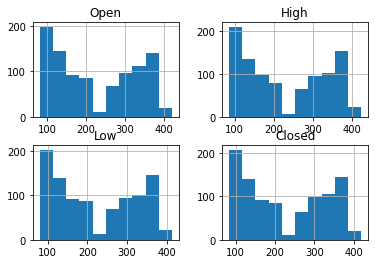

In [2]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4]
# df.iloc[행 인덱스, 열 인덱스] : 행이나 컬럼의 순서를 나타내는 정수로 특정 값을 추출해오는 방식
data_used['Closed'] = data['Close']
hist = data_used.hist()
plt.show()

# 출력값의 범위가 커지면, 오차의 범위도 커져서 기울기가 커지기 때문에 정규화 필요함


In [3]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset


class Netflix(Dataset):
    def __init(self):
        # 데이터 읽기
        self.csv = pd.read_csv('./dataset/netflix-stock-prediction/train.csv')
        
        # 입력 데이터 정규화
        self.data = self.csv.iloc[:,1:4].valuse # 종가 제외한 데이터
        self.data = self.data / np.max(self.data) # 0과 1사이로 정규화
        
        # 종가 데이터 정규화
        self.label = data['Close'].valuse
        self.label = self.label / np.max(self.label)
        
    def __len__(self):
        return len(self.data) - 30
    
    def __getitem__(self, i):
        data = self.data[i:i+30]
        label = self.label[i+30]
        
        return data, label
    

/opt/conda/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        # RNN층의 정의
        self.rnn = nn.RNN(input_size =3, hidden_size = 8, num_layers = 5,
                          batch_first = True)
        # input_size = 입력 텐서의 특징 개수 / 개장가, 최고가, 최저가를 하나로 묶어서 3임
        # hidden_size = RNN 층에서 각 시점의 차원 
        # num_layers = RNN의 층 개수 > 일반적으로 5나 3을 사용
        # batch_first = 배치를 가장 앞으로 오게함 
        # 현재 개장가, 최고가, 최저가를 30일치 묵었기 때문에 (30,3) 모양을 갖는 텐서를 (32,30,3)으로 만들어 줌
        # false면 (30,3,32)
        
    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)  # RNN 층의 출력
        
        # MLP층의 입력으로 사용되게 모양 변경
        x = torch.reshape(x, (x.shape[0], -1))
        
        # MLP층을 이용해 종가 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # 예측한 종가를 1차원 벡터로 표현
        x = torch.flatten(x)
        
        return x
        


In [ ]:
import tqdm

from torch.optim.adam import Adam
from torch.utilx.data.dataloader import DataLoader

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_availabel() else 'cpu'

model = RNN().to(device)
dataset = Netflix()
loader = DataLoader(dataset, batch_size = 32)
optim = Adam(params = model.parameters(), lr = 0.0001) 

for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        
        # 초기 은닉 상태
        h0 = torch.zeros(5, data.shape[0],8).to(device)
        
        # 모델의 예측값
        pred = model(data.type(torch.FloatTensor).to(device),h0)
        
        # 손실의 계산
        loss = nn.MSELoss()(pred,
                            label.type(torch.FloatTensor).to(device)
        loss.backward()
        optim.step()
        iterator.set_description(f'epoch{epoch} loss:{loss.item)}')
torch.save(model.state_dict(), './rnn.pth') # 모델 저장

loader = DataLoader(dataset, batch_size = 1)
preds = []
total_loss = 0

        